In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def matrix_mul(input, weight, bias=False):
    feature_list = []
    for feature in input:
        feature = torch.mm(feature, weight)
        if isinstance(bias, torch.nn.parameter.Parameter):
            feature = feature + bias.expand(feature.size()[0], bias.size()[1])
        feature = torch.tanh(feature).unsqueeze(0)
        feature_list.append(feature)

    return torch.cat(feature_list, 0).squeeze()

In [3]:
def element_wise_mul(input1, input2):

    feature_list = []
    for feature_1, feature_2 in zip(input1, input2):
        feature_2 = feature_2.unsqueeze(1).expand_as(feature_1)
        feature = feature_1 * feature_2
        feature_list.append(feature.unsqueeze(0))
    output = torch.cat(feature_list, 0)

    return torch.sum(output, 0).unsqueeze(0)

In [4]:
class WordAttNet(nn.Module):
    def __init__(self, hidden_size=50):
        super(WordAttNet, self).__init__()

        self.word_weight = nn.Parameter(torch.Tensor(2 * hidden_size, 2 * hidden_size))
        nn.init.xavier_uniform_(self.word_weight)
        self.word_bias = nn.Parameter(torch.Tensor(1, 2 * hidden_size))
        nn.init.xavier_uniform_(self.word_bias)
        self.context_weight = nn.Parameter(torch.Tensor(2 * hidden_size, 1))
        nn.init.xavier_uniform_(self.context_weight)

        self.fc_out = nn.Linear(1, 64)
        self.gru = nn.GRU(64, hidden_size, bidirectional=True)
        self._create_weights(mean=0.0, std=0.05)

    def _create_weights(self, mean=0.0, std=0.05):

        self.word_weight.data.normal_(mean, std)
        self.context_weight.data.normal_(mean, std)

    def forward(self, inputs, hidden_state):

        inputs = inputs.unsqueeze(-1)
        output = self.fc_out(inputs)
        f_output, h_output = self.gru(output.float(), hidden_state)  # feature output and hidden state output
        output = matrix_mul(f_output, self.word_weight, self.word_bias)
        output = matrix_mul(output, self.context_weight).permute(1,0)
        output = F.softmax(output)
        output = element_wise_mul(f_output,output.permute(1,0))

        return output, h_output

In [5]:
class SentAttNet(nn.Module):
    def __init__(self, sent_hidden_size=50, word_hidden_size=50, num_classes=14):
        super(SentAttNet, self).__init__()

        self.sent_weight = nn.Parameter(torch.Tensor(2 * sent_hidden_size, 2 * sent_hidden_size))
        nn.init.xavier_uniform_(self.sent_weight)
        self.sent_bias = nn.Parameter(torch.Tensor(1, 2 * sent_hidden_size))
        nn.init.xavier_uniform_(self.sent_bias)
        self.context_weight = nn.Parameter(torch.Tensor(2 * sent_hidden_size, 1))
        nn.init.xavier_uniform_(self.context_weight)

        self.gru = nn.GRU(2 * word_hidden_size, sent_hidden_size, bidirectional=True)
        self.fc = nn.Linear(2 * sent_hidden_size, num_classes)
        # self.sent_softmax = nn.Softmax()
        # self.fc_softmax = nn.Softmax()
        self._create_weights(mean=0.0, std=0.05)

    def _create_weights(self, mean=0.0, std=0.05):
        self.sent_weight.data.normal_(mean, std)
        self.context_weight.data.normal_(mean, std)

    def forward(self, inputs, hidden_state):

        f_output, h_output = self.gru(inputs, hidden_state)
        output = matrix_mul(f_output, self.sent_weight, self.sent_bias)
        output = matrix_mul(output, self.context_weight).permute(1, 0)
        output = F.softmax(output)
        output = element_wise_mul(f_output, output.permute(1, 0)).squeeze(0)
        output = self.fc(output)

        return output, h_output

In [6]:
class HierAttNet(nn.Module):
    def __init__(self, word_hidden_size, sent_hidden_size, num_classes):
        super(HierAttNet, self).__init__()
        self.word_hidden_size = word_hidden_size
        self.sent_hidden_size = sent_hidden_size
        self.word_att_net = WordAttNet(word_hidden_size)
        self.sent_att_net = SentAttNet(sent_hidden_size, word_hidden_size, num_classes)
        self.final_layer = nn.Linear(num_classes, 1)

    def forward(self, inputs):

        batch_size = inputs.shape[0]
        self.word_hidden_state = torch.zeros(2, batch_size, self.word_hidden_size)
        self.sent_hidden_state = torch.zeros(2, batch_size, self.sent_hidden_size)
        if torch.cuda.is_available():
            self.word_hidden_state = self.word_hidden_state.cuda()
            self.sent_hidden_state = self.sent_hidden_state.cuda()

        output_list = []
        inputs = inputs.permute(1, 0, 2)
        for i in inputs:
            output, self.word_hidden_state = self.word_att_net(i.permute(1, 0), self.word_hidden_state)
            output_list.append(output)
        output = torch.cat(output_list, 0)
        output, self.sent_hidden_state = self.sent_att_net(output, self.sent_hidden_state)
        output = self.final_layer(output)

        return output

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
word_hidden_size=64
sent_hidden_size=64
num_classes=10
model = HierAttNet(word_hidden_size, sent_hidden_size, num_classes).to(device)

In [8]:
x = torch.randn(5, 20, 22).to(device=device)
y = model(x)
print(y.shape)
print(y)

torch.Size([5, 1])
tensor([[-0.0430],
        [-0.0407],
        [-0.0381],
        [-0.0401],
        [-0.0382]], device='cuda:0', grad_fn=<AddmmBackward0>)


<ipython-input-4-e83b62209f17>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(output)
<ipython-input-5-6dee060c5c30>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(output)


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [10]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)

In [11]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [12]:
df_for_training=df[feature_names].astype(float)

In [13]:
df_for_training.shape

(11524, 22)

In [14]:
scaler=MinMaxScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [15]:
trainX=[]
trainY=[]

In [16]:
n_future=1
n_past=20

In [17]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [18]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11504, 20, 22).
trainY shape==(11504, 1).


In [19]:
trainX_copy,trainY_copy=trainX.copy(),trainY.copy()

In [20]:
def random_shuffle(data,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data,label

In [21]:
data,label=random_shuffle(trainX,trainY)

In [22]:
# Create a DataLoader for the training data
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [24]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        #output = model(data1, data2)
        output = model(data)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

<ipython-input-4-e83b62209f17>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(output)
<ipython-input-5-6dee060c5c30>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(output)
C:\Users\abc\AppData\Roaming\Python\Python38\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.19573765993118286
Epoch: 1 Loss: 0.2719274163246155
Epoch: 2 Loss: 0.2656169831752777
Epoch: 3 Loss: 0.1067562997341156
Epoch: 4 Loss: 0.1460060179233551
Epoch: 5 Loss: 0.2594403624534607
Epoch: 6 Loss: 0.19282348453998566
Epoch: 7 Loss: 0.06472117453813553
Epoch: 8 Loss: 0.34161463379859924
Epoch: 9 Loss: 0.1331043243408203
Epoch: 10 Loss: 0.09377778321504593
Epoch: 11 Loss: 0.15005527436733246
Epoch: 12 Loss: 0.17724859714508057
Epoch: 13 Loss: 0.18895044922828674
Epoch: 14 Loss: 0.07721662521362305
Epoch: 15 Loss: 0.06413707137107849
Epoch: 16 Loss: 0.07821016013622284
Epoch: 17 Loss: 0.18083496391773224
Epoch: 18 Loss: 0.04061424732208252
Epoch: 19 Loss: 0.1278657764196396
Epoch: 20 Loss: 0.04210919886827469
Epoch: 21 Loss: 0.038993608206510544
Epoch: 22 Loss: 0.10742224752902985
Epoch: 23 Loss: 0.10882668197154999
Epoch: 24 Loss: 0.12118501961231232
Epoch: 25 Loss: 0.04476868361234665
Epoch: 26 Loss: 0.06138987094163895
Epoch: 27 Loss: 0.017734801396727562
Epoch: 

Epoch: 224 Loss: 0.022296978160738945
Epoch: 225 Loss: 0.07575753331184387
Epoch: 226 Loss: 0.03624587878584862
Epoch: 227 Loss: 0.011563356034457684
Epoch: 228 Loss: 0.02533533051609993
Epoch: 229 Loss: 0.02251618541777134
Epoch: 230 Loss: 0.009021846577525139
Epoch: 231 Loss: 0.032771386206150055
Epoch: 232 Loss: 0.015906503424048424
Epoch: 233 Loss: 0.02736058458685875
Epoch: 234 Loss: 0.045835040509700775
Epoch: 235 Loss: 0.00826610904186964
Epoch: 236 Loss: 0.03475135192275047
Epoch: 237 Loss: 0.026918236166238785
Epoch: 238 Loss: 0.0312001071870327
Epoch: 239 Loss: 0.012197699397802353
Epoch: 240 Loss: 0.022858839482069016
Epoch: 241 Loss: 0.030281376093626022
Epoch: 242 Loss: 0.019548144191503525
Epoch: 243 Loss: 0.025383777916431427
Epoch: 244 Loss: 0.03660314530134201
Epoch: 245 Loss: 0.03307326138019562
Epoch: 246 Loss: 0.05376520752906799
Epoch: 247 Loss: 0.03741437569260597
Epoch: 248 Loss: 0.02215815708041191
Epoch: 249 Loss: 0.018878471106290817
Epoch: 250 Loss: 0.0083484

Epoch: 443 Loss: 0.039644479751586914
Epoch: 444 Loss: 0.0077377259731292725
Epoch: 445 Loss: 0.038831762969493866
Epoch: 446 Loss: 0.012184969149529934
Epoch: 447 Loss: 0.006687970831990242
Epoch: 448 Loss: 0.01482841931283474
Epoch: 449 Loss: 0.03634810447692871
Epoch: 450 Loss: 0.0052198488265275955
Epoch: 451 Loss: 0.03558642417192459
Epoch: 452 Loss: 0.03921803832054138
Epoch: 453 Loss: 0.025767706334590912
Epoch: 454 Loss: 0.05302538722753525
Epoch: 455 Loss: 0.01730118691921234
Epoch: 456 Loss: 0.037721678614616394
Epoch: 457 Loss: 0.012789370492100716
Epoch: 458 Loss: 0.029931988567113876
Epoch: 459 Loss: 0.01571224071085453
Epoch: 460 Loss: 0.017801228910684586
Epoch: 461 Loss: 0.049199461936950684
Epoch: 462 Loss: 0.02021913230419159
Epoch: 463 Loss: 0.021400656551122665
Epoch: 464 Loss: 0.028154755011200905
Epoch: 465 Loss: 0.024651354178786278
Epoch: 466 Loss: 0.016717107966542244
Epoch: 467 Loss: 0.008582265116274357
Epoch: 468 Loss: 0.008116347715258598
Epoch: 469 Loss: 0

Epoch: 661 Loss: 0.04441285505890846
Epoch: 662 Loss: 0.006796312518417835
Epoch: 663 Loss: 0.01841837912797928
Epoch: 664 Loss: 0.004842107649892569
Epoch: 665 Loss: 0.018249772489070892
Epoch: 666 Loss: 0.02256062999367714
Epoch: 667 Loss: 0.011538779363036156
Epoch: 668 Loss: 0.011294882744550705
Epoch: 669 Loss: 0.021051600575447083
Epoch: 670 Loss: 0.021846149116754532
Epoch: 671 Loss: 0.013041699305176735
Epoch: 672 Loss: 0.026623234152793884
Epoch: 673 Loss: 0.025814417749643326
Epoch: 674 Loss: 0.027003483846783638
Epoch: 675 Loss: 0.003650551661849022
Epoch: 676 Loss: 0.009490781463682652
Epoch: 677 Loss: 0.013089330866932869
Epoch: 678 Loss: 0.024628520011901855
Epoch: 679 Loss: 0.025696296244859695
Epoch: 680 Loss: 0.009011518210172653
Epoch: 681 Loss: 0.013431170023977757
Epoch: 682 Loss: 0.011026047170162201
Epoch: 683 Loss: 0.017933953553438187
Epoch: 684 Loss: 0.02021944336593151
Epoch: 685 Loss: 0.019726164638996124
Epoch: 686 Loss: 0.02310698665678501
Epoch: 687 Loss: 

Epoch: 879 Loss: 0.020131614059209824
Epoch: 880 Loss: 0.012591501697897911
Epoch: 881 Loss: 0.012630654498934746
Epoch: 882 Loss: 0.013155777007341385
Epoch: 883 Loss: 0.014696115627884865
Epoch: 884 Loss: 0.01179412193596363
Epoch: 885 Loss: 0.012538492679595947
Epoch: 886 Loss: 0.011168790981173515
Epoch: 887 Loss: 0.02441161870956421
Epoch: 888 Loss: 0.015187840908765793
Epoch: 889 Loss: 0.02154739387333393
Epoch: 890 Loss: 0.011764364317059517
Epoch: 891 Loss: 0.0065691182389855385
Epoch: 892 Loss: 0.01803593710064888
Epoch: 893 Loss: 0.017398493364453316
Epoch: 894 Loss: 0.006290045101195574
Epoch: 895 Loss: 0.005867191590368748
Epoch: 896 Loss: 0.016076382249593735
Epoch: 897 Loss: 0.0051813083700835705
Epoch: 898 Loss: 0.03523311764001846
Epoch: 899 Loss: 0.012023434974253178
Epoch: 900 Loss: 0.012493612244725227
Epoch: 901 Loss: 0.053139474242925644
Epoch: 902 Loss: 0.00761294923722744
Epoch: 903 Loss: 0.00873205903917551
Epoch: 904 Loss: 0.02287730947136879
Epoch: 905 Loss: 0

In [25]:
test_data = torch.from_numpy(trainX_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [26]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    data = data.to(device=device)
    output = model(data)
    targets = targets.to(device=device)
    predictions+=output.tolist()

<ipython-input-4-e83b62209f17>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(output)
<ipython-input-5-6dee060c5c30>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.softmax(output)


In [27]:
predictions = np.array(predictions)

In [28]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [29]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

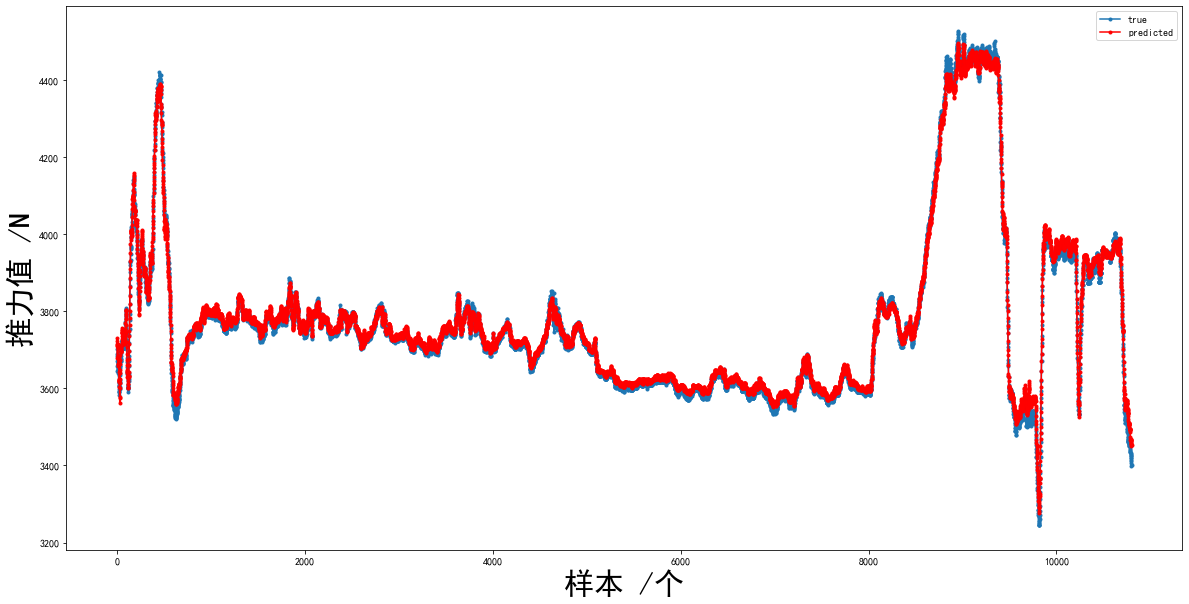

In [30]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();